Script to analyze the accessibility of huts based on the difficulty and number of hiking trails reaching them.

# BASIC IDEA
Work with OSMnx an Networkx to analyze trails to huts using graphs.

For each hut:
1. count number of distinct trails leading to it
2. for each trail, compute the cost of arriving:
    - take start and end of trail
    - consider the DEM
    - compute time and effort of the itinerary
3. compare with categoria CAISAT

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
import rasterio
import random
import pickle
import os

import warnings
warnings.simplefilter("ignore")

In [5]:
# Save results to
os.makedirs('../data/graphs/', exist_ok=True)
results_dir = '../data/graphs/'

In [6]:
# Load hut data for coordinates (in mcdm_analysis.ipynb can use merged_df)
huts_gdf = gpd.read_file('../data/huts/huts_points.geojson')
huts_gdf.drop(columns='posti_letto', inplace=True)
huts_gdf = huts_gdf.to_crs(epsg=32632)

# Load trails data
trails_gdf = gpd.read_file('../data/trails/Sentieri_della_SAT.shp')
trails_gdf = trails_gdf.to_crs(huts_gdf.crs)

# All trails graph creation
To create a OSMx graph (easy plotting and access), first I need to create 2 GeoDataFrames: one for nodes and one for edges.

In [4]:
def extract_nodes(trails_gdf):
    ''' Extract nodes (start and end points of LineStrings) ''' 

    print('Extracting nodes...')
    nodes = []
    node_to_trail = {} # id: numero

    for idx, row in trails_gdf.iterrows():
        # Get start and end points from the LineString
        start_point = Point(row.geometry.coords[0])
        end_point = Point(row.geometry.coords[-1])

        # Add to nodes list with unique ID
        nodes.append({'id': f'{idx}_start', 'geometry': start_point, 'numero': row['numero']})
        nodes.append({'id': f'{idx}_end', 'geometry': end_point, 'numero': row['numero']})

        # Add nodes' ids to dictionary for mapping to numbers
        start_node = f'{idx}_start'
        end_node = f'{idx}_end'
        trail_numero = row['numero']
        node_to_trail[start_node] = trail_numero
        node_to_trail[end_node] = trail_numero

    # Convert to GeoDataFrame
    nodes_gdf = gpd.GeoDataFrame(nodes, crs=trails_gdf.crs)
    # Drop duplicate nodes 
    nodes_gdf = nodes_gdf.drop_duplicates(subset=['geometry']).reset_index(drop=True)
    
    # Add x and y columns from the geometry
    nodes_gdf['x'] = nodes_gdf.geometry.x
    nodes_gdf['y'] = nodes_gdf.geometry.y

    # Set the 'id' column as the index
    nodes_gdf.set_index('id', inplace=True)
    
    return nodes_gdf, node_to_trail


def extract_edges(trails_gdf, nodes_gdf):
    ''' Extract edges from trails_gdf with numero as an attribute '''
    
    print('Extracting edges...')
    edges = []
    for idx, row in trails_gdf.iterrows():
        # Get start and end points
        start_node = row.geometry.coords[0]
        end_node = row.geometry.coords[-1]

        # Find node indices
        start_idx = nodes_gdf[nodes_gdf.geometry == Point(start_node)].index[0]
        end_idx = nodes_gdf[nodes_gdf.geometry == Point(end_node)].index[0]

        # Create an edge with 'numero' as an attribute
        edges.append({
            'u': start_idx,   # Start node
            'v': end_idx,     # End node
            'key': 0,         # Key for handling multiple edges between same nodes
            'geometry': row.geometry,
            'numero': row['numero'],  # Add 'numero' trail identifier
            'length': row.geometry.length
        })

    # Convert to GeoDataFrame
    edges_gdf = gpd.GeoDataFrame(edges, crs=trails_gdf.crs)

    # Set MultiIndex (u, v, key)
    edges_gdf.set_index(['u', 'v', 'key'], inplace=True)
    
    print(f'Extracted {len(edges_gdf)} edges.')
    return edges_gdf


In [7]:
# Generate nodes and edges GeoDataFrames
nodes_gdf, node_to_trail = extract_nodes(trails_gdf)
edges_gdf = extract_edges(trails_gdf, nodes_gdf)

# Create the graph
G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)


Extracting nodes...
Extracting edges...
Extracted 1049 edges.


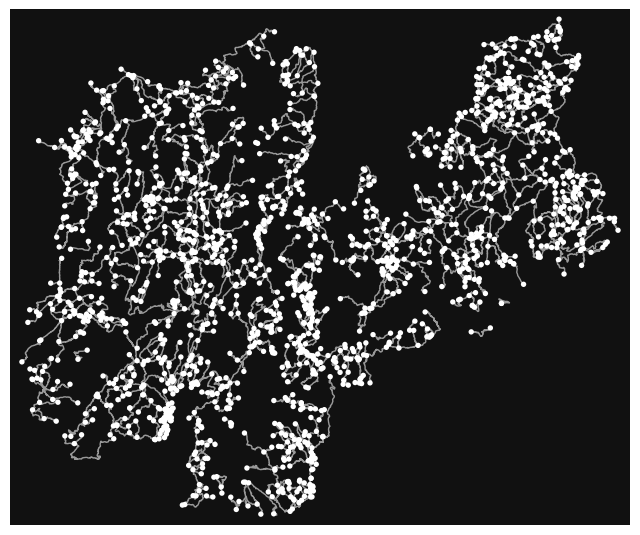

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
ox.plot_graph(G)

In [9]:
# Check node structure
for node, data in G.nodes(data=True):
    print(node, data)
    break

0_start {'numero': 'E106', 'x': 653619.719998705, 'y': 5066118.310120334}


In [10]:
# Check edge structure
for u, v, data in G.edges(data=True):
    print(u, v, data)
    break

0_start 0_end {'geometry': <LINESTRING (653619.72 5066118.31, 653633.57 5066088.25, 653645.59 5066072.7...>, 'numero': 'E106', 'length': 6514.51084652241}


Add elevation to the graph

In [11]:
def get_elevation_from_dem(nodes_gdf, dem_path='../data/terrain/clipped_dem.tif'):
    print('Extracting elevation from DEM...')

    with rasterio.open(dem_path) as dem_data:
        elevations = []

        for idx, row in nodes_gdf.iterrows():
            coord = [(row['x'], row['y'])]

            # Extract the elevation at the given coordinate
            for val in dem_data.sample(coord):
                elevation = val[0]
                elevations.append(elevation)

        nodes_gdf['elevation'] = elevations

    return nodes_gdf

In [12]:
# Extract elevation for each node
nodes_gdf = get_elevation_from_dem(nodes_gdf)

# Add the elevation as a node attribute to the graph
for idx, row in nodes_gdf.iterrows():
    G.nodes[idx]['elevation'] = row['elevation']


Extracting elevation from DEM...


In [13]:
# Save graph in file
with open(results_dir + 'graph_all_trails.pkl', 'wb') as f:
    pickle.dump(G, f)

In [14]:
# Save as geojson for QGIS visualization
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
gdf_nodes.to_file(results_dir + 'graph_all_trails_nodes.geojson', driver='GeoJSON')
gdf_edges.to_file(results_dir + 'graph_all_trails_edges.geojson', driver='GeoJSON')

# Analysis
Analyze the accessibility via hiking trails of each hut:
1. create a subgraph of the trails connected to the hut (nearest node in the graph)
2. identify trailheads in the subgraph
3. compute the shortest path to the hut from each trailhead (with length and elevation gain)

Note: no need to create the graph, if present in ../data/graphs/ it will be loaded

In [12]:
# Create a dictionary mapping node IDs to trail numbers ('numero')
node_to_trail = {}

for idx, row in trails_gdf.iterrows():
    # Map start and end nodes to the trail's numero
    start_node = f'{idx}_start'
    end_node = f'{idx}_end'
    trail_numero = row['numero']
    
    node_to_trail[start_node] = trail_numero
    node_to_trail[end_node] = trail_numero

In [7]:
def find_nearest_node(huts_gdf, G):
    ''' Finds the nearest node in the graph for each hut.
    Saves node id in a new column 'nearest_node' '''
    nearest_nodes = []
    for idx, hut in huts_gdf.iterrows():
        hut_point = hut.geometry
        nearest_node = ox.distance.nearest_nodes(G, hut_point.x, hut_point.y)
        nearest_nodes.append(nearest_node)
    huts_gdf['nearest_node'] = nearest_nodes
    return huts_gdf

def compute_shortest_paths(subgraph, hut_node):
    # Find trailheads in the subgraph
    trailheads = [node for node, degree in subgraph.degree if degree == 1]
    shortest_paths = {}
    
    # Compute shortest path from each trailhead to the hut
    for trailhead in trailheads:
        if nx.has_path(subgraph, trailhead, hut_node):
            path = nx.shortest_path(subgraph, source=trailhead, target=hut_node, weight='length')
            shortest_paths[trailhead] = path
    return shortest_paths
    
def compute_path_metrics(G, path):
    '''
    Computes the length and elevation gain of a given path in the graph.
    
    Parameters:
    - G: a graph.
    - path: A list of nodes representing the shortest path.
    
    Returns:
    - A dictionary with 'length' and 'elevation_gain'.
    '''
    # Calculate the total length of the path
    length = nx.path_weight(G, path, weight='length')
    length = round(length, 2)
    
    # Calculate elevation gain
    elevation_gain = 0
    for i in range(1, len(path)):
        start_node = path[i - 1]
        end_node = path[i]
        
        # Get elevations
        start_elevation = G.nodes[start_node]['elevation']
        end_elevation = G.nodes[end_node]['elevation']
        
        # Only consider positive elevation change
        if end_elevation > start_elevation:
            elevation_gain += (end_elevation - start_elevation)
            elevation_gain = round(elevation_gain, 2)

    return {'length': length, 'elevation_gain': elevation_gain}

def save_all_subgraphs(subgraphs:dict, filename= results_dir + "subgraphs_trails_to_huts.pkl"):
    '''
    Saves all subgraphs to a single file using pickle.
    
    Parameters:
    - subgraphs: A dictionary of subgraphs keyed by hut name.
    - filename: The filename to save the subgraphs. Default is "subgraphs.pkl".
    '''
    with open(filename, 'wb') as f:
        pickle.dump(subgraphs, f)
    print(f"Saved all subgraphs to {filename}")

In [31]:
def compute_path_metrics_with_time(G, path):
    '''
    Computes the length, elevation gain, and estimated walking time of a given path in the graph.
    
    Parameters:
    - G: a graph.
    - path: A list of nodes representing the shortest path.
    
    Returns:
    - A dictionary with 'length' [km], 'elevation_gain' [m], and 'estimated_time [hrs]'.
    '''
    # Calculate the total length of the path
    length = nx.path_weight(G, path, weight='length')  # length is in meters
    length_km = length / 1000  # convert to kilometers
    length_km = round(length_km, 2)
    
    # Calculate elevation gain
    elevation_gain = 0
    for i in range(1, len(path)):
        start_node = path[i - 1]
        end_node = path[i]
        
        # Get elevations
        start_elevation = G.nodes[start_node]['elevation']
        end_elevation = G.nodes[end_node]['elevation']
        
        # Only consider positive elevation change
        if end_elevation > start_elevation:
            elevation_gain += (end_elevation - start_elevation)
            elevation_gain = round(elevation_gain, 2)

    # Estimate walking time (Naismith's Rule)
    estimated_time = (length_km / 5) + (elevation_gain / 600)  # time in hours
    estimated_time = round(estimated_time, 2)
    
    return {
        'length': length_km,
        'elevation_gain': elevation_gain,
        'estimated_time': estimated_time
    }


In [32]:
def analysis(huts_gdf, G, save_subgraphs=False):
    # 1. Find nearest nodes for each hut
    huts_gdf = find_nearest_node(huts_gdf, G)

    # Initialize dictionaries to store the results & subgraphs
    hut_metrics = {}
    all_subgraphs = {}

    print(f'Processing...')
    # 2. Find connected nodes with Breadth-first search
    for idx, row in huts_gdf.iterrows():
        nearest_node = row['nearest_node']
        G_undir = G.to_undirected()
        connected_nodes = nx.node_connected_component(G_undir, nearest_node)
        
        # 3. Create subgraph with connected trails
        subgraph = G_undir.subgraph(connected_nodes).copy()

        # store the subgraph in the dictionary using the hut name as the key
        hut_name = row['standard_name']  
        all_subgraphs[hut_name] = subgraph

        # 4. Compute shortest paths from trailheads to the hut
        shortest_paths = compute_shortest_paths(subgraph, nearest_node)

        # 5. Compute length and elevation gain for each path
        # Store metrics for each path
        hut_metrics[row['standard_name']] = {}
        
        for start_node, path in shortest_paths.items():
            metrics = compute_path_metrics_with_time(subgraph, path)
            hut_metrics[row['standard_name']][start_node] = {
            'path': path,
            'length': metrics['length'],
            'elevation_gain': metrics['elevation_gain'],
            'estimated_time': metrics['estimated_time']
            }
            # hut_metrics[row['standard_name']][start_node] = {}
            # hut_metrics[row['standard_name']][start_node]['path'] = path
            # hut_metrics[row['standard_name']][start_node]['length'] = metrics['length']
            # hut_metrics[row['standard_name']][start_node]['elevation_gain'] = metrics['elevation_gain']

    if save_subgraphs:
        # Save all subgraphs at once
        save_all_subgraphs(all_subgraphs)

    return hut_metrics, all_subgraphs

In [33]:
# Perform path search and analysis
try:
    hut_metrics, all_subgraphs = analysis(huts_gdf, G, save_subgraphs=True)
except NameError:
    print("Loading graph from file...")
    with open(results_dir + 'graph_all_trails.pkl', 'rb') as f:
        G = pickle.load(f)
        
    hut_metrics, all_subgraphs = analysis(huts_gdf, G, save_subgraphs=True)

# Check results
no_paths = [hut for hut, metrics in hut_metrics.items() if not metrics]
if no_paths:
    print(f"No paths were found for hut: {empty_huts}")
else:
    print("Found paths for all huts.")

Processing...
Saved all subgraphs to ../data/graphs/subgraphs_trails_to_huts.pkl
Found paths for all huts.


In [18]:
# To load the subgraphs back
filename = results_dir + "subgraphs_trails_to_huts.pkl"
with open(filename, 'rb') as f:
    subgraphs = pickle.load(f)


## Example results

In [19]:
huts_gdf.standard_name.unique()

array(['alpepozzavlancia', 'altissimodchiesa', 'antermoia',
       'bindesipprati', 'boccaditratnpernici', 'boè', 'carèaltodongari',
       'casarotalciola', 'cevedaleglarcher', 'ciampediè',
       'cimadastaobrentari', 'fftucketteqsella', 'finonchiofllifilzi',
       'grostèggraffer', 'mandroncittàditrento', 'montecalinosanpietro',
       'monzonittaramelli', 'paludei', 'peller', 'rodadivael',
       'rosettagpedrotti', 'saentsdorigoni', 'setteselle', 'stavelfdenza',
       'stivopmarchetti', 'tosaetpedrotti', 'vaiolet',
       'valdambiezsagostini', 'valdamolagsegantini', 'valdifumo',
       'velomadonna', 'vioz', 'xiiapostoliflligarbari'], dtype=object)

In [52]:
hut_name = 'monzonittaramelli'
res = hut_metrics[hut_name]
res

{'476_end': {'path': ['476_end',
   '476_start',
   '473_end',
   '462_end',
   '492_end',
   '431_start',
   '431_end'],
  'length': 34.49,
  'elevation_gain': 1179.76,
  'estimated_time': 8.86},
 '469_end': {'path': ['469_end', '437_start', '431_start', '431_end'],
  'length': 25.26,
  'elevation_gain': 97.49,
  'estimated_time': 5.21},
 '505_end': {'path': ['505_end',
   '471_start',
   '437_start',
   '431_start',
   '431_end'],
  'length': 29.33,
  'elevation_gain': 376.57,
  'estimated_time': 6.49},
 '495_end': {'path': ['495_end',
   '462_start',
   '462_end',
   '492_end',
   '431_start',
   '431_end'],
  'length': 34.37,
  'elevation_gain': 880.29,
  'estimated_time': 8.34},
 '455_start': {'path': ['455_start', '431_end'],
  'length': 4.0,
  'elevation_gain': 493.66,
  'estimated_time': 1.62},
 '498_start': {'path': ['498_start',
   '462_end',
   '492_end',
   '431_start',
   '431_end'],
  'length': 27.81,
  'elevation_gain': 1518.81,
  'estimated_time': 8.09},
 '526_start': {

In [53]:
print(f"Found {len(res)} paths to hut {hut_name}.")
for start_node, metrics in res.items():
    path_numbers = [node_to_trail[node] for node in metrics['path']]
    print(f"\nShortest path from {node_to_trail[start_node]}: {path_numbers}")
    print(f"Length: {metrics['length']} km")
    print(f"Elevation gain: {metrics['elevation_gain']} m")
    print(f"Estimated time: {metrics['estimated_time']} hours")
    

Found 9 paths to hut monzonittaramelli.

Shortest path from E616B: ['E616B', 'E616B', 'E614', 'E623', 'E628', 'E604', 'E604']
Length: 34.49 km
Elevation gain: 1179.76 m
Estimated time: 8.86 hours

Shortest path from E606: ['E606', 'E607', 'E604', 'E604']
Length: 25.26 km
Elevation gain: 97.49 m
Estimated time: 5.21 hours

Shortest path from E640: ['E640', 'E608', 'E607', 'E604', 'E604']
Length: 29.33 km
Elevation gain: 376.57 m
Estimated time: 6.49 hours

Shortest path from E631: ['E631', 'E623', 'E623', 'E628', 'E604', 'E604']
Length: 34.37 km
Elevation gain: 880.29 m
Estimated time: 8.34 hours

Shortest path from E603: ['E603', 'E604']
Length: 4.0 km
Elevation gain: 493.66 m
Estimated time: 1.62 hours

Shortest path from E632: ['E632', 'E623', 'E628', 'E604', 'E604']
Length: 27.81 km
Elevation gain: 1518.81 m
Estimated time: 8.09 hours

Shortest path from E660: ['E660', 'E623', 'E628', 'E604', 'E604']
Length: 27.54 km
Elevation gain: 1710.13 m
Estimated time: 8.36 hours

Shortest pat

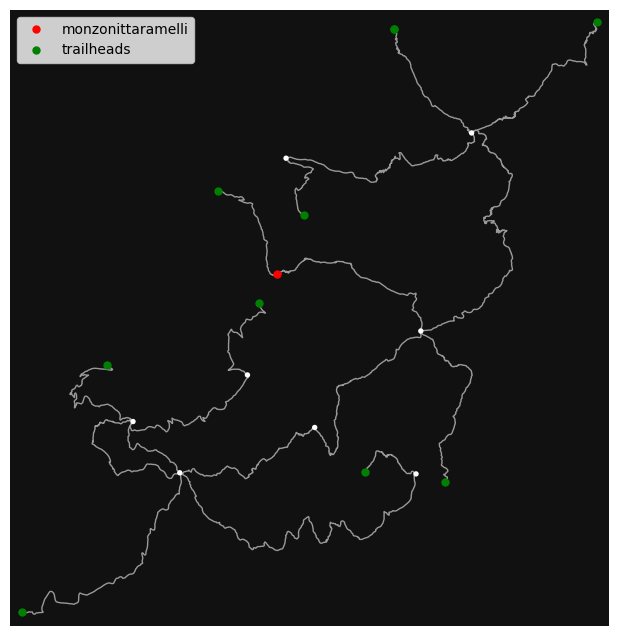

In [54]:
# Plot subgraph with hut
hut_geom = huts_gdf[huts_gdf['standard_name'] == hut_name]['geometry'].values[0]
subgraph = all_subgraphs[hut_name]

fig, ax = ox.plot_graph(subgraph, show=False, close=False)
# plot hut in red
ax.plot(hut_geom.x, hut_geom.y, 'ro', markersize=5, label=hut_name)
# plot trailheads in green
trailheads = [key for key,val in res.items()]
for trailhead in trailheads:
    ax.plot(subgraph.nodes[trailhead]['x'], subgraph.nodes[trailhead]['y'], 'go', markersize=5)
    # at last, add trailheads label
    if trailhead == trailheads[-1]:
        ax.plot(subgraph.nodes[trailhead]['x'], subgraph.nodes[trailhead]['y'], 'go', markersize=5, label=f'trailheads')

plt.legend()


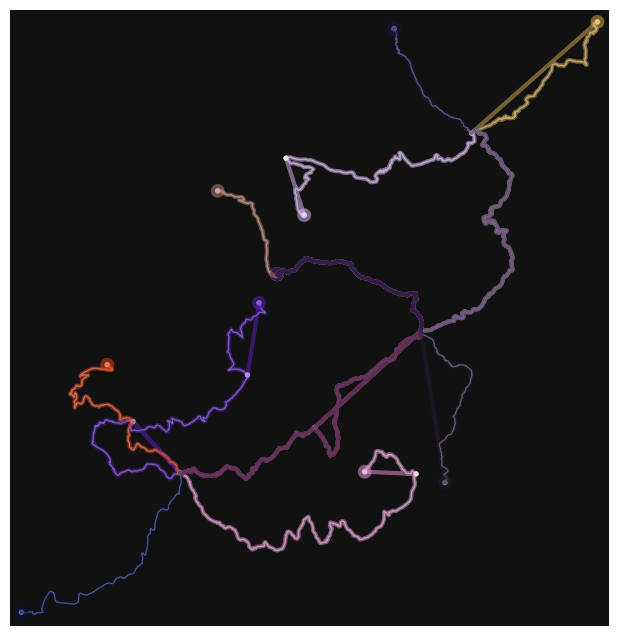

In [65]:
routes = [res[key]['path'] for key in res.keys()]
colors = ["#{:06x}".format(random.randint(0, 0xFFFFFF)) for _ in routes]

fig, ax = ox.plot_graph_routes(subgraph, routes, route_colors=colors, route_linewidths=3)

# Comparison with categoria_CAISAT
The CAI-SAT classification for mountain huts is defined in [Regolamento strutture ricettive del Club Alpino Italiano](https://www.cai.it/wp-content/uploads/2020/12/Regolamento-strutture-ricettive-del-Club-Alpino-Italiano-20201.pdf) (Allegato 1).

It is based on 2 main criteria: **ease of access** for visitors and mode of **hut supplying**. More details:

- A: huts reachable by customers with a _private car_ or within a maximum of 10 minutes on foot from the car park. Situations where the customer reaches the refuge (or the immediate vicinity) by paying a ticket are also included. 
- B: refuges reachable by _cable car_, or in the immediate vicinity (within 10 minutes on foot from the arrival of the cable car); 
- C, D, E:  The parameter for ease of reaching is the _hours of walking_ according to the CAI table. 

As regards the means of transport for supplies/equipment, it is assumed that the cost by helicopter is the highest while the goods-aerialway has a one-off cost that can be amortised over several years. 
It is assumed that a refuge supplied by helicopter must be at least in class D or higher. 
It is assumed that a refuge in order to be in class E must always be more than 4 hours' walking away.

In the simultaneous availability of different means of supply, the assigned class is the lowest. 

In the case that a hut does _not have water availability_, and must be continuously supplied with tanks, the classification increases by one unit. (example from C to D and from D to E). This must be structural and not temporary for a season.

TABLE:

|walking time|vehicle|aerialway|helicopter|
|---|---|---|---|
|10 min - 2 hrs|C|C|D|
|2 hrs - 4 hrs|C|D|D|
|>4 hrs|D|E|E|


## 1. Hut supply information
First I need to get the hut supplying strategies for each hut (same code as mcdm_analysis.ipynb).

Aerialways 
criteria: within a 500m buffer

In [21]:
goods_aerialways = gpd.read_file('../data/others/goods_aerialways.geojson')
goods_aerialways = goods_aerialways.to_crs(huts_gdf.crs)

huts_gdf['buffer'] = huts_gdf.geometry.buffer(500)

# Check for intersections between the buffered huts and the aerialways
huts_gdf['supply_aerialway'] = huts_gdf['buffer'].apply(
    lambda hut_buffer: goods_aerialways.intersects(hut_buffer).any()
)
huts_gdf = huts_gdf.drop(columns=['buffer'])

# Values of the new column
huts_gdf.supply_aerialway.value_counts()

supply_aerialway
False    18
True     15
Name: count, dtype: int64

Helicopter
criteria: Cevedale, Dorigoni, Stivo, Val di Fumo, Boè, Sette Selle, Rosetta, Vioz (Source: SAT)

In [23]:
heli = ['cevedaleglarcher', 'saentsdorigoni', 'stivopmarchetti', 'valdifumo', 'boè', 'setteselle', 'rosettagpedrotti', 'vioz']

def define_helicopter_supply(row):
    if row['standard_name'] in heli:
        return True
    else:
        return False

huts_gdf['supply_helicopter'] = huts_gdf.apply(define_helicopter_supply, axis=1)
huts_gdf['supply_helicopter'].value_counts()

supply_helicopter
False    25
True      8
Name: count, dtype: int64

Vehicle
criteria: if a road for vehicles is connected to the hut, it is assumed to be used for supplying.

In [24]:
buffer_dist = 300  # (more than 300 becomes less accurate (gets Stivo which does not have car access))
huts_with_road = {}

huts_gdf4326 = huts_gdf.to_crs(epsg=4326) # OSMnx uses WGS84 [degrees] 
for idx, hut in huts_gdf4326.iterrows():
    hut_point = hut.geometry

    # Get network of roads within a certain distance from the hut's location
    roads_gdf = ox.features.features_from_point(
        (hut_point.y, hut_point.x),
        tags={'highway': True},  # Fetch all roads with 'highway' tag
        dist=buffer_dist
    )

    # Filter vehicle roads (OSM docs key:highway)
    roads_for_vehicles = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'service', 'track'] # track=forestale/agricola
    vehicle_roads = roads_gdf[roads_gdf['highway'].isin(roads_for_vehicles)]
    
    if not vehicle_roads.empty:
      huts_with_road[hut['standard_name']] = vehicle_roads['highway'].unique()

# Create column
for idx, row in huts_gdf.iterrows():
    if row['standard_name'] in huts_with_road:
        huts_gdf.at[idx, 'supply_road'] = True
    else:
        huts_gdf.at[idx, 'supply_road'] = False

In [25]:
# Combine all supply modes in a single column
def combine_supply_modes(row):
    supply_mode = []
    if row['supply_aerialway']:
        supply_mode.append('aerialway')
    if row['supply_helicopter']:
        supply_mode.append('helicopter')
    if row['supply_road']:
        supply_mode.append('vehicle')
    
    return supply_mode

huts_gdf['supply_modes'] = huts_gdf.apply(combine_supply_modes, axis=1)


## Visitors access information
Need to get information about:
- lifts (cable car, etc.): lift within a 500m (~10min walk) buffer from hut.
- car access (public road): if categoria_PAT=="Escurs" it means there is car access.

In [27]:
lifts_aerialways = gpd.read_file('../data/others/lifts_aerialways.geojson')
lifts_aerialways = lifts_aerialways.to_crs(huts_gdf.crs)

def get_lift_ids_within_buffer(hut_buffer):
    lifts_aerialways_linestring = lifts_aerialways[lifts_aerialways.geometry.type == 'LineString']
    intersecting_lifts = lifts_aerialways_linestring[lifts_aerialways_linestring.intersects(hut_buffer)]
    if not intersecting_lifts.empty:
        # Return all the lift IDs that intersect within the 2300m buffer
        return set(intersecting_lifts['id'])
    else:
        return None

# Directly accessible via lift (<10 min walk)
huts_gdf['buffer_500'] = huts_gdf.geometry.buffer(500)
huts_gdf['lift_ids_within_500m'] = huts_gdf['buffer_500'].apply(get_lift_ids_within_buffer)
huts_gdf = huts_gdf.drop(columns=['buffer_500'])

# Simplified accessibility via lift
huts_gdf['buffer_2300'] = huts_gdf.geometry.buffer(2300)
huts_gdf['lift_ids_within_2300m'] = huts_gdf['buffer_2300'].apply(get_lift_ids_within_buffer)
huts_gdf = huts_gdf.drop(columns=['buffer_2300'])


In [28]:
huts_gdf['car_access'] = huts_gdf['categoria_PAT'].apply(lambda x: True if x == 'Escurs' else False)

### Computation of hiking time
Average hiking time for each hut over all its paths.

## Evaluation algorithm
TODO: implement the rules of the Regolamento to validate the CAI-SAT category.